# Setup and Imports

In [18]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")


from sklearn.cluster import KMeans

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# DF
df = pd.read_csv("/content/drive/MyDrive/TFM_EasyMoney/datasets_diccionario_TFM/df_cust_clean.csv")
df.head()

,pk_cid,active_customer,age,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,...,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_OTHERS,entry_channel_RED,grupo_edad_25-35,grupo_edad_35-45,grupo_edad_45-55,grupo_edad_55+
0,657826,1.0,44,54493.38,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,657817,0.0,32,103655.58,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,657986,1.0,39,100993.17,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,657905,1.0,85,154059.09,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,657336,1.0,38,105118.08,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Preparación de la Base de Datos

Se trabaja con un dataframe previamente ajustado, con feaatures creados y limpiado, es por eso que para la preparación de datos únicamente se considera relevante definir cuáles serán los features más relevantes para tratar en el modelo de clustering según el objetivo de negocios.

## Feature Engineering

La gran mayoría del feature engineering fue realizado en la etapa previa de limpieza con el fin de poder utilizar dichos features tanto para este modelo de clusterización como también para los modelos de propensión de compra de productos por cliente.

Los features que serán creados a continuación se realizan en esta etapa debido a que su naturaleza podría suponer data leakage en caso de hablerlos creado e incluido previamente en la etapa anterior debido a que contienen información de la variable objetivo de los modelos de propensión de compra.

### Number of Products

Cantidad de productos activos que tiene el cliente

In [21]:
df['nr_products'] = (
      df['em_acount']
    + df['debit_card']
    + df['credit_card']
    + df['payroll']
    + df['payroll_account']
    + df['emc_account']
    + df['short_term_deposit']
    + df['funds']
    + df['long_term_deposit']
    + df['securities']
    + df['loans']
    + df['pension_plan']
    + df['mortgage']
)


### Engagement Score

**Clasificación de productos y pesos**

1. Bajo compromiso (score = 1)

***em_acount*** → Cuenta básica de ahorro, bajo vínculo, fácilmente reemplazable.

***debit_card*** → Producto de uso masivo, bajo costo de cambio, engagement bajo.

***credit_card*** → Aunque genera ingresos transaccionales, no implica compromiso a largo plazo.

***payroll*** → Servicio transaccional (domiciliación de nómina), fácil de mover a otro banco.

2. Medio compromiso (score = 2)

***payroll_account*** → Relacionada con nómina pero más estable que solo el servicio “payroll”.

***emc_account*** → Inversión especulativa/cripto, tiene cierto riesgo y requiere interés activo.

***short_term_deposit*** → Bloquea dinero por un tiempo limitado, genera compromiso moderado.

***funds*** → Implica una decisión de inversión pero relativamente líquida.

3. Alto compromiso (score = 3)

***long_term_deposit*** → Bloqueo de capital a largo plazo, más difícil moverlo.

***securities*** → Inversiones en bolsa, requieren planificación y suelen tener mayor ticket promedio.

***loans*** → Obligación de pago recurrente, alto nivel de compromiso financiero.

4. Muy alto compromiso (score = 4)

***pension_plan*** → Horizonte de muy largo plazo, compromiso altísimo con la entidad.

***mortgage*** → Endeudamiento de 15–30 años, probablemente retenga al cliente en el banco.

In [22]:
df['engagement_score'] = (
      1 * (df['em_acount']
           + df['debit_card']
           + df['credit_card']
           + df['payroll'])
    + 2 * (df['payroll_account']
           + df['emc_account']
           + df['short_term_deposit']
           + df['funds'])
    + 3 * (df['long_term_deposit']
           + df['securities']
           + df['loans'])
    + 4 * (df['pension_plan']
           + df['mortgage'])
)

## Reducción de Dimensionalidad

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440244 entries, 0 to 440243
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pk_cid                      440244 non-null  int64  
 1   active_customer             440244 non-null  float64
 2   age                         440244 non-null  int64  
 3   salary                      440244 non-null  float64
 4   short_term_deposit          440244 non-null  int64  
 5   loans                       440244 non-null  int64  
 6   mortgage                    440244 non-null  int64  
 7   funds                       440244 non-null  int64  
 8   securities                  440244 non-null  int64  
 9   long_term_deposit           440244 non-null  int64  
 10  em_account_pp               440244 non-null  int64  
 11  credit_card                 440244 non-null  int64  
 12  payroll                     440244 non-null  float64
 13  pension_plan  

In [24]:
# Guardar los IDs de clientes en una variable
customer_ids = df["pk_cid"]

# Dropear la columna de IDs del dataframe de features
df = df.drop(columns=["pk_cid"])

**FEATURES PARA MODELO DE CLUSTERING**

**1. Comportamiento**

- ***active_customer*** → indicador binario (activo/inactivo). Muy útil para

diferenciar clientes vigentes vs dormidos.

- ***months_since_last_purchase*** → mide recencia, clave para saber si el cliente sigue interactuando.

- ***tenure*** → tiempo como cliente, ayuda a distinguir nuevos de antiguos.


- ***engagement_score*** → intensidad del vínculo a través de tipo de productos, más allá de cantidad.

**2. Sociodemográfico**

- ***age*** → distribución generacional, distintos perfiles de riesgo y productos.

- ***salary*** → nivel socioeconómico, afecta probabilidad de adquirir ciertos productos.

- ***segment*** → permite capturar diferencias en tipo de cliente (aunque es categórica, puede ser codificada).

**3. Monetario**

- ***cust_profit_17m*** → valor generado en margen en 17 meses, identifica clientes rentables.

- ***transactions_17m*** → volumen de interacción (frecuencia de transacciones).

**4. Producto / Riesgo**

- ***debt_score*** → exposición a productos de deuda, proxy de riesgo crediticio.

- ***debt_income_score*** → ajusta deuda respecto a ingresos, mejor indicador de riesgo relativo.

- ***nr_products*** → amplitud del portafolio del cliente, muestra nivel de diversificación.

In [25]:
# Definir columnas que queremos conservar
cols_to_keep = [
    "active_customer",
    "segment_universitario",
    "age",
    "salary",
    "debt_score",
    "debt_income_score",
    "cust_profit_17m",
    "transactions_17m",
    "months_since_last_purchase",
    "engagement_score",
    "tenure",
    "nr_products"
]

df_cluster = df[cols_to_keep]

## Preprocessing

### Escalado de Datos

In [26]:

scaler = RobustScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# lo convierto de nuevo a DataFrame con mismos nombres de columnas
df_cluster = pd.DataFrame(df_cluster_scaled,
                          columns=df_cluster.columns,
                          index=df_cluster.index)

In [27]:
df_cluster

,active_customer,segment_universitario,age,salary,debt_score,debt_income_score,cust_profit_17m,transactions_17m,months_since_last_purchase,engagement_score,tenure,nr_products
0,1.0,-1.0,1.461538,-0.580565,0.0,0.00000,0.000000,0.0,0.000,0.0,1.083333,0.0
1,0.0,-1.0,0.538462,0.262664,0.0,0.00000,0.000000,0.0,0.000,-1.0,-0.916667,-1.0
2,1.0,-1.0,1.076923,0.216998,1.0,0.00001,0.993837,1.0,-0.375,10.0,0.708333,5.0
3,1.0,-1.0,4.615385,1.127184,0.0,0.00000,0.000000,0.0,0.000,3.0,0.208333,1.0
4,1.0,-1.0,1.000000,0.287749,0.0,0.00000,1.052388,1.0,-2.000,0.0,-0.833333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
440239,0.0,0.0,-0.230769,-0.762054,0.0,0.00000,0.000000,0.0,0.000,0.0,0.458333,0.0
440240,0.0,0.0,-0.153846,-1.114993,0.0,0.00000,0.873652,1.0,-0.875,0.0,0.458333,0.0
440241,1.0,-1.0,1.692308,-0.188238,0.0,0.00000,0.000000,0.0,0.000,0.0,0.458333,0.0
440242,0.0,0.0,-0.230769,1.908178,0.0,0.00000,0.000000,0.0,0.000,0.0,0.458333,0.0


# Elbow Curve

In [28]:
sse = {}

for k in range(2, 15):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_cluster_scaled)

    sse[k] = clustering_model.inertia_

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters


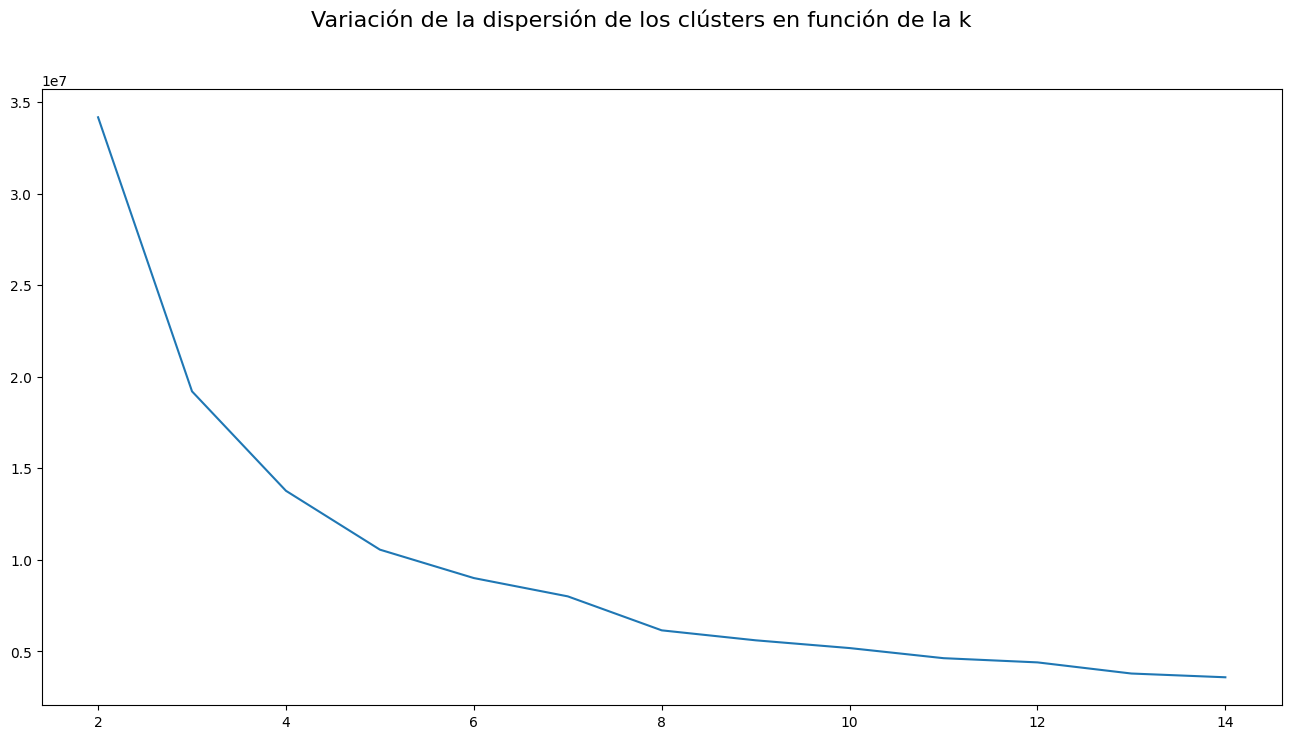

In [29]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

En esta sección vamos a visualizar nuestro ***Elbow Curve*** y buscaremos el punto de inflexión que será nuestro número de centroides.

# Aplicación de KMeans

In [30]:
# Definir el modelo
kmeans = KMeans(n_clusters=5, random_state=166)

# Ajustar el modelo en datos escalados
kmeans.fit(df_cluster_scaled)

# Obtener etiquetas de cluster
labels = kmeans.labels_

In [32]:
df_scaled_clusters = df_cluster_scaled.copy()
df_scaled_clusters["cluster"] = labels

In [33]:
df_cluster = pd.DataFrame(
    scaler.inverse_transform(df_cluster_scaled),
    columns=df_cluster_scaled.columns
)
df_cluster["cluster"] = labels

In [34]:
# --- Agrupación de features ---
feature_groups = {
    "Comportamiento": ["active_customer", "months_since_last_purchase", "tenure", "engagement_score"],
    "Sociodemográfico": ["age", "salary", "segment_02 - PARTICULARES", "segment_universitario"],
    "Monetario": ["cust_profit_17m", "transactions_17m"],
    "Producto/Riesgo": ["debt_score", "debt_income_score", "nr_products"]
}

# Invertir diccionario → mapping feature → grupo
feature_to_group = {f: g for g, feats in feature_groups.items() for f in feats}

# --- Generar describe con agrupación ---
summary = (
    df_cluster
    .groupby("cluster")
    .describe()
    .T
    .reset_index()
    .rename(columns={"level_0": "feature", "level_1": "stat"})
)

# Añadir columna de grupo
summary["group"] = summary["feature"].map(feature_to_group)

# Reordenar columnas
summary = summary[["group", "feature", "stat"] + [c for c in summary.columns if c not in ["group", "feature", "stat"]]]

summary.loc[summary["feature"] == "debt_income_score", summary.columns[3:]] *= 1_000_000
# --- Visualización con escala de color ---
(
    summary
    .set_index(["group", "feature", "stat"])
    .style
    .format("{:.2f}")
    .background_gradient(cmap="Blues", axis=1)  # escala horizontal (por cluster)
)


# Interpretación de los Clusters

**Cluster 0 – Pasivos Masivos**

- **Tamaño:** *413K (muy dominante en la base).*
- **Comportamiento:** Solo *35% activos*, engagement muy bajo *(1.0)*, meses sin compra altos *(14)*.  
- **Sociodemográfico:** Jóvenes *(30 años promedio)*, *67% universitarios*.  
- **Productos/Riesgo:** *0.9 productos en promedio*, deuda casi inexistente *(0.01)*.  
- **Monetario:** Rentabilidad casi nula *(24).*  

➡️ **Interpretación:** Base amplia de clientes jóvenes, poco vinculados, bajo riesgo, sin deuda, pero de poco valor.  
**Acción:** Estrategias de activación / cross-selling inicial *(ej. productos simples: debit_card, em_acount).*  

---

**Cluster 1 – Clientes Vinculados Premium**

- **Tamaño:** *9K*.  
- **Comportamiento:** *95% activos*, engagement alto *(5.7)*, pocas compras sin realizar *(6 meses desde última compra).*  
- **Sociodemográfico:** Edad media *(36 años)*, *34% universitarios.*  
- **Productos/Riesgo:** *2.85 productos*, deuda baja *(0.05).*  
- **Monetario:** Alta rentabilidad *(4.6K)*, alto volumen transaccional *(3.8).*  

➡️ **Interpretación:** Clientes activos y rentables, multivinculados.  
**Acción:** Retención prioritaria + upselling productos de valor agregado *(fondos, inversiones).*  

---

**Cluster 2 – Deudores Rentables**

- **Tamaño:** *2.5K*.  
- **Comportamiento:** Muy activos *(95%)*, alto engagement *(6.0).*  
- **Sociodemográfico:** Jóvenes-adultos *(35 años promedio).*  
- **Productos/Riesgo:** *3 productos*, deuda moderada *(0.06)*, DTI más alto *(0.68).*  
- **Monetario:** Muy alta rentabilidad *(10.4K, la más alta).*  

➡️ **Interpretación:** Cartera pequeña pero extremadamente rentable, vinculados con productos de deuda e ingresos medios.  
**Acción:** Expandir oferta de deuda *(créditos adicionales, tarjetas premium)*, cuidando riesgo.  

---

**Cluster 3 – Seniors Conservadores**

- **Tamaño:** *8.5K*.  
- **Comportamiento:** *84% activos*, engagement medio *(3.7)*, meses desde última compra un poco más altos *(7.7).*  
- **Sociodemográfico:** Mayores *(47 años promedio)*, bajo % universitario *(9%).*  
- **Productos/Riesgo:** *1.9 productos promedio*, deuda baja *(0.03).*  
- **Monetario:** Rentabilidad baja *(1.8K).*  

➡️ **Interpretación:** Clientes senior, conservadores, poco rentables, con bajo riesgo.  
**Acción:** Mantener con productos de bajo riesgo *(depósitos a plazo, seguros)*, sin foco en expansión agresiva.  

---

**Cluster 4 – Multivinculados Endeudados**

- **Tamaño:** *7.2K*.  
- **Comportamiento:** Muy activos *(95%)*, engagement alto *(5.9).*  
- **Sociodemográfico:** Edad media *(35 años)*, *35% universitarios.*  
- **Productos/Riesgo:** *3 productos*, deuda presente *(0.06)*, DTI más alto del grupo *(0.72).*  
- **Monetario:** Alta rentabilidad *(7.0K).*  

➡️ **Interpretación:** Clientes vinculados y rentables, con deuda significativa.  
**Acción:** Potenciar cross-selling financiero *(seguros, fondos)*, monitorear riesgo de sobreendeudamiento.  


In [35]:
# Diccionario para renombrar clusters a nombres más comerciales
cluster_names = {
    0: "Pasivos Masivos",
    1: "Clientes Vinculados Premium",
    2: "Deudores Rentables",
    3: "Seniors Conservadores",
    4: "Multivinculados Endeudados"
}

In [36]:
# --- Diccionario de nombres comerciales ---
cluster_names = {
    0: "Pasivos Masivos",
    1: "Clientes Vinculados Premium",
    2: "Deudores Rentables",
    3: "Seniors Conservadores",
    4: "Multivinculados Endeudados"
}

# --- Agrupación de features ---
feature_groups = {
    "Comportamiento": ["active_customer", "months_since_last_purchase", "tenure", "engagement_score"],
    "Sociodemográfico": ["age", "salary", "segment_02 - PARTICULARES", "segment_universitario"],
    "Monetario": ["cust_profit_17m", "transactions_17m"],
    "Producto/Riesgo": ["debt_score", "debt_income_score", "nr_products"]
}

# Invertir diccionario → mapping feature → grupo
feature_to_group = {f: g for g, feats in feature_groups.items() for f in feats}

# --- Generar describe con agrupación ---
summary = (
    df_cluster
    .groupby("cluster")
    .describe()
    .T
    .reset_index()
    .rename(columns={"level_0": "feature", "level_1": "stat"})
)

# Renombrar columnas de clusters usando nombres comerciales
summary = summary.rename(columns={c: cluster_names.get(c, c) for c in summary.columns})

# Añadir columna de grupo
summary["group"] = summary["feature"].map(feature_to_group)

# Reordenar columnas
summary = summary[["group", "feature", "stat"] + [c for c in summary.columns if c not in ["group", "feature", "stat"]]]

# Escalar deuda si quieres
summary.loc[summary["feature"] == "debt_income_score", summary.columns[3:]] *= 1_000_000

# --- Visualización con escala de color ---
(
    summary
    .set_index(["group", "feature", "stat"])
    .style
    .format("{:.2f}")
    .background_gradient(cmap="Blues", axis=1)  # escala horizontal (por cluster)
)

# Definición de Segmentos

In [39]:
# --- Diccionario de nombres comerciales ---
cluster_names = {
    0: "Pasivos Masivos",
    1: "Clientes Vinculados Premium",
    2: "Deudores Rentables",
    3: "Seniors Conservadores",
    4: "Multivinculados Endeudados"
}

# Crear df_segmentos con pk_cid y segmento
df_segmentos = pd.DataFrame({
    "pk_cid": customer_ids.values.flatten(),   # asegurar que es 1D
    "cluster": [cluster_names[label] for label in labels]
})

df_segmentos.head()


,pk_cid,cluster
0,657826,Pasivos Masivos
1,657817,Pasivos Masivos
2,657986,Pasivos Masivos
3,657905,Pasivos Masivos
4,657336,Pasivos Masivos


In [40]:
df_segmentos.to_csv("df_segmentos.csv", index=False)